# Expected Improvement BO


In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Import the class
import torch
import yaml

## Customizing the UpperConfidenceBound Generator
First lets examine the possible options that we can specify for the
UpperConfidenceBound generator. We can use these keys to customize optimization.

In [2]:
from xopt.generators import get_generator_and_defaults
ei_gen, ei_options = get_generator_and_defaults("expected_improvement")
print(yaml.dump(ei_options.dict()))

acq:
  monte_carlo_samples: 128
  proximal_lengthscales: null
  use_transformed_proximal_weights: true
model:
  function: !!python/name:xopt.generators.bayesian.models.standard.create_standard_model ''
  kwargs:
    use_conservative_prior_lengthscale: false
    use_conservative_prior_mean: false
    use_low_noise_prior: false
n_initial: 3
optim:
  max_travel_distances: null
  num_restarts: 5
  raw_samples: 20
  sequential: true
  use_nearby_initial_points: true



In [3]:
from xopt.resources.test_functions.rosenbrock import make_rosenbrock_vocs, evaluate_rosenbrock
from xopt import Xopt, Evaluator
import pandas as pd

vocs = make_rosenbrock_vocs(2)

generator_options = ei_gen.default_options()
generator_options.optim.num_restarts = 20
generator_options.optim.max_travel_distances = [0.1, 0.1]
generator_options.model.kwargs.use_low_noise_prior = True
#generator_options.acq.proximal_lengthscales = [0.01, 0.01]

evaluator = Evaluator(function=evaluate_rosenbrock)
generator = ei_gen(vocs, generator_options)


In [4]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

for i in range(100):
    X.step()
    print(f"step {i}: best: {X.data['y'].min()}")


step 0: best: 13.441458139755563
step 1: best: 7.379223529381661
step 2: best: 0.8581476259026024
step 3: best: 0.8581476259026024
step 4: best: 0.8581476259026024
step 5: best: 0.8581476259026024
step 6: best: 0.8581476259026024
step 7: best: 0.8581476259026024
step 8: best: 0.8581476259026024
step 9: best: 0.8581476259026024
step 10: best: 0.8581476259026024
step 11: best: 0.8581476259026024
step 12: best: 0.8581476259026024
step 13: best: 0.8581476259026024
step 14: best: 0.8581476259026024
step 15: best: 0.8581476259026024
step 16: best: 0.8581476259026024
step 17: best: 0.8581476259026024
step 18: best: 0.8581476259026024
step 19: best: 0.8581476259026024
step 20: best: 0.8581476259026024
step 21: best: 0.8581476259026024
step 22: best: 0.8581476259026024
step 23: best: 0.8581476259026024
step 24: best: 0.8581476259026024
step 25: best: 0.8581476259026024
step 26: best: 0.8581476259026024
step 27: best: 0.8581476259026024
step 28: best: 0.8581476259026024
step 29: best: 0.85814762

## View output data

In [5]:
X.data

,x0,x1,y,xopt_runtime,xopt_error
1,0.146574,-1.968437,396.706684,0.000020,False
2,1.593503,-1.993074,2054.550582,0.000005,False
3,0.549230,0.665498,13.441458,0.000004,False
4,0.369654,0.400877,7.379224,0.000015,False
5,0.415484,0.244494,0.858148,0.000014,False
...,...,...,...,...,...
98,-1.421804,1.297999,58.214474,0.000015,False
99,-1.609458,1.068047,238.551681,0.000015,False
100,-1.732892,1.024341,398.943510,0.000015,False
101,-1.552284,0.965531,215.043583,0.000015,False


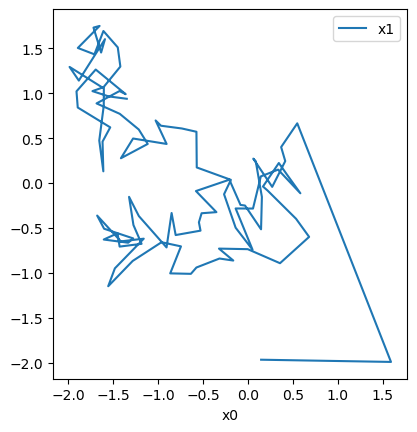

In [6]:
# plot results
ax = X.data.plot(*vocs.variable_names)
ax.set_aspect("equal")

## Visualize model used by upper confidence bound
Models are kept in a list, in this case that list has one element, the model
created for the objective `y1`.


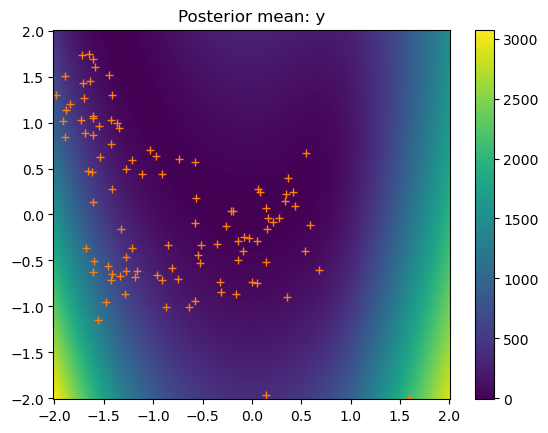

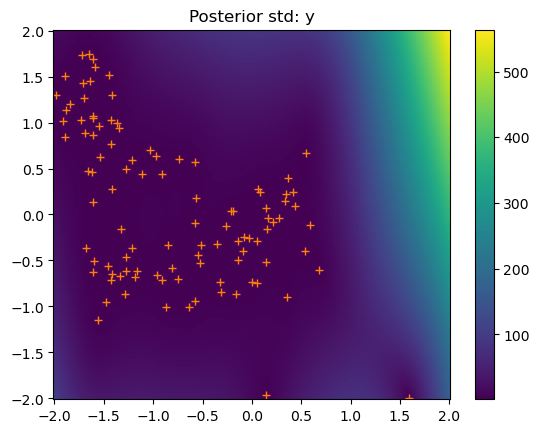

In [7]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax.pcolor(xx, yy, mean.reshape(n, n))
    fig.colorbar(c)
    ax.set_title(f"Posterior mean: {outputs[0]}")

    fig2, ax2 = plt.subplots()
    ax2.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax2.pcolor(xx, yy, std.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title(f"Posterior std: {outputs[0]}")

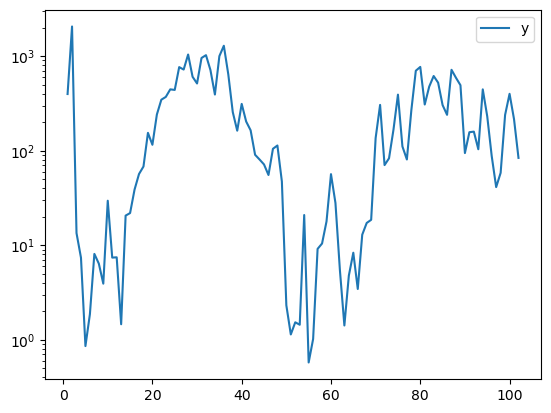

In [8]:
ax = X.data.plot(y="y", logy=True)

In [9]:
# Cleanup
!rm dump.yaml

rm: cannot remove 'dump.yaml': No such file or directory
